In [1]:
import itertools as it
import os
import pickle
import re
from copy import deepcopy
from functools import reduce
from glob import glob
from operator import add, itemgetter
from pprint import pprint

import gensim
import gensim.downloader as api
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from scipy.spatial.distance import pdist, squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.preprocessing import LabelEncoder, PowerTransformer

from utils import video_id_without_categories

wv = api.load('word2vec-google-news-300')

/home/hylomorph/Study/ped/yt_trending_videos/venv/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Ground Truth

In [2]:
with open('data/category_id.pkl', 'rb') as fh:
    data = pickle.load(fh)

idx = [[(item['id'], int(item['snippet']['categoryId'])) for item in batch['items']] for batch in data]
idx = reduce(add, idx, [])

df = pd.read_pickle('data/chkp2.pkl')
unknown_idx = video_id_without_categories(df)
print("Liczba nieznanych kategorii")
print(unknown_idx.shape)

print("Filmy niedostępne na YouTube")
print(len(set(unknown_idx) - set(map(itemgetter(0),idx))))

Liczba nieznanych kategorii
(5768,)
Filmy niedostępne na YouTube
556


In [3]:
category_map = df.groupby('category_id')['category_text'].max()

In [4]:
category_map

category_id
1.0          Film & Animation
2.0          Autos & Vehicles
10.0                    Music
15.0           Pets & Animals
17.0                   Sports
19.0          Travel & Events
20.0                   Gaming
22.0           People & Blogs
23.0                   Comedy
24.0            Entertainment
25.0          News & Politics
26.0            Howto & Style
27.0                Education
28.0     Science & Technology
29.0    Nonprofits & Activism
43.0                    Shows
Name: category_text, dtype: object

In [5]:
df.groupby('category_id').count()

,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,...,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
category_id,,,,,,,,,,,,,,,,,,,,,
1.0,166,166,166,166,166,166,166,166,166,166,...,155,155,155,155,155,155,155,155,155,155
2.0,16,16,16,16,16,16,16,16,16,16,...,13,13,13,13,13,13,13,13,13,13
10.0,608,608,608,608,608,608,608,608,608,608,...,580,580,580,580,580,580,580,580,580,580
15.0,49,49,49,49,49,49,49,49,49,49,...,47,47,47,47,47,47,47,47,47,47
17.0,183,183,183,183,183,183,183,183,183,183,...,173,173,173,173,173,173,173,173,173,173
19.0,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
20.0,95,95,95,95,95,95,95,95,95,95,...,86,86,86,86,86,86,86,86,86,86
22.0,241,241,241,241,241,241,241,241,241,241,...,214,214,214,214,214,214,214,214,214,214
23.0,220,220,220,220,220,220,220,220,220,220,...,187,187,187,187,187,187,187,187,187,187


In [6]:
kaggle_df =  pd.concat([
    pd.read_csv(path, usecols=['video_id', 'category_id']) for path in glob('data/kaggle/*.csv')
]).groupby('video_id').max()

category_df = pd.DataFrame(np.array(idx), columns=['video_id', 'category_id']).set_index('video_id')
category_df = pd.concat([category_df, kaggle_df.loc[list(set(unknown_idx) - set(map(itemgetter(0),idx))), :]])
category_df['category_id'] = category_df.category_id.astype(int)
category_df

,category_id
video_id,
9wRQljFNDW8,17
Om_zGhJLZ5U,1
goP4Z5wyOlM,25
8NHA23f7LvU,24
IE-xepGLVt8,28
...,...
PtR_Wzf94C4,26
I6YQz96PYvw,1
xxQhWrAcQnE,24


# Analiza cech

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8606 entries, 9wRQljFNDW8 to 4YFo4bdMO8Q
Columns: 123 entries, trending_date to iqr_blue
dtypes: bool(5), datetime64[ns, UTC](1), datetime64[ns](3), float32(1), float64(45), int64(47), object(19), timedelta64[ns](2)
memory usage: 7.8+ MB


In [8]:
pd.options.display.max_columns = 1000
df.head(3)

,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_date_end,trending_date_start,trending_span,trending_span_days,publish_to_trending_span,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,emotions,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,2017-11-13 02:05:26+00:00,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...,US,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,0 days 21:54:34,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,True,False,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[person, person, person, person, person, perso...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[brood, cantmiss, playe, lewis, yard, return, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,2017-11-12 18:00:03+00:00,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...,US,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,1 days 05:59:57,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.00

In [9]:
to_int = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'is_us', 'is_gb']
df[to_int] = df[to_int].astype(int)
df.head(3)

,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_date_end,trending_date_start,trending_span,trending_span_days,publish_to_trending_span,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,emotions,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,2017-11-14,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,2017-11-13 02:05:26+00:00,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,0,0,0,New England Patriots returner Dion Lewis blast...,US,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,0 days 21:54:34,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[person, person, person, person, person, perso...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,[],0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[brood, cantmiss, playe, lewis, yard, return, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,2017-11-12 18:00:03+00:00,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,0,0,0,With Justice League approaching fast we rewatc...,US,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,2017-11-14,2017-11-14,0 days,0,1 days 05:59:57,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,

In [10]:
to_ingore = ['trending_date', 'title', 'channel_title', 'publish_time', 'thumbnail_link', 
             'description', 'origin', 'trending_date_end', 'trending_date_start', 'trending_span', 'publish_to_trending_span',
             'emotions']

df.drop(to_ingore, axis=1, inplace=True)
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[person, person, person, person, person, perso...","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[brood, cantmiss, playe, lewis, yard, return, ...",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[person, person, person]","(person, 0.87004745)",person,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[tlsdw, scteen, long, didnt, watch, junkies]",68.507153,31.0,114.0,66.

### Liczenie wektorów cech dla kolumn z tekstem

In [11]:
text_to_process = ['image_text', 'tags', 'objects']

# Preprocess tags
stopwords_list = list(stopwords.words('english'))
def preprocess_tags(sentence):
    wordtokens = word_tokenize(re.sub('[^A-Za-z]+', ' ', sentence.lower()))
    wordtokens = [word for word in wordtokens if (word not in stopwords_list) and (len(word) > 2) and not (word.isnumeric())]
    return wordtokens

df['tags'] = df['tags'].apply(preprocess_tags)

df[text_to_process].head(3)

,image_text,tags,objects
video_id,,,
9wRQljFNDW8,"[brood, cantmiss, playe, lewis, yard, return, ...","[nfl, football, offense, defense, afc, nfc, am...","[person, person, person, person, person, perso..."
Om_zGhJLZ5U,"[tlsdw, scteen, long, didnt, watch, junkies]","[screenjunkies, screen, junkies, news, honest,...","[person, person, person]"
goP4Z5wyOlM,"[tehran, ahalabja, iraq, baghdad, iran, news]","[bbc, bbc, news, news, iran, iran, news, iraq,...",[]


In [12]:
df_temp = deepcopy(df[text_to_process])

def word_averaging(wv, sequence):
    mean = []
    try:
        for word in sequence:
            if word in wv.key_to_index:
                mean.append(wv.get_vector(word))
    except:
        return np.zeros(300,)
    if not mean: return np.zeros(300,)
    return gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)

def word_averaging_list(wv, sequences):
    return np.vstack([word_averaging(wv, w) for w in sequences])

def embedding_model(text, name):
    # Word averaging
    wa = word_averaging_list(wv, text)
    # Replace cols
    df_temp[name] = list(wa)

for col in text_to_process:
    embedding_model(df_temp[col].values, col)

df[text_to_process] = df_temp
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....","(person, 0.5387666)",person,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....","(person, 0.87004745)",person,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153

### Przetworzenie pozostałych kolumn

In [13]:
to_encode = ['most_occurence_object']
df[to_encode] = LabelEncoder().fit_transform(df[to_encode].values.ravel())
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....","(person, 0.5387666)",46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....","(person, 0.87004745)",46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153,31.0,11

In [14]:
to_untuple = ['max_prob_object']
df[to_untuple] = LabelEncoder().fit_transform(df[to_untuple].\
    applymap(lambda x: x[0] if isinstance(x, tuple) else 'none').fillna('none').values.ravel())
df.head(3)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0

### Sprawdzanie statystyk dla cech wektorowych

In [15]:
to_embeddings = ['description_embedding', 'title_embedding', 'feature_vector', 'hist_reds', 'hist_greens', 'hist_blues', 'fisher_vector']
import tqdm

embeddings_statistics = []
for col in tqdm.tqdm(to_embeddings):
    unwrapped_df = df[col].apply(lambda x: pd.Series(x, dtype='float32'))
    correlation = unwrapped_df.corrwith(df.category_id, method='spearman')
    correlation = correlation.describe()
    correlation['name'] = col
    embeddings_statistics.append(correlation)

100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


<AxesSubplot:ylabel='name'>

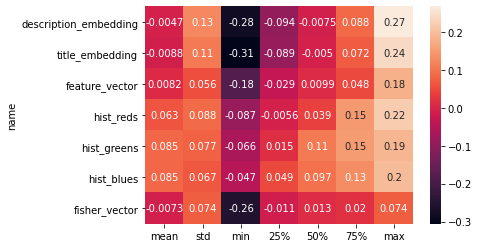

In [16]:
stats_df = pd.concat(embeddings_statistics, axis=1).T.set_index('name').astype('float32')
stats_df.drop('count', axis=1, inplace=True)
sns.heatmap(stats_df, annot=True)

### PCA dla cech wektorowych

Ponieważ oryginalne cechy wektorowe miały dużą liczbę wymiarów, to dodanie ich jako cech (gdzie, każdy wymiar były dodany jako osobna cecha) zabużyłoby już istniejące cechy. Dlatego zastosowaliśmy PCA, aby zredukować liczbę wymiarów cech wektorowych. Niestety, cechy wektorowe obrazków są problematyczne ponieważ nie każdy film miał obrazek, dlatego zrezygnowaliśmy z nich. 

In [17]:
to_embeddings = ['description_embedding', 'title_embedding', 'feature_vector', 'hist_reds', 'hist_greens', 'hist_blues', 'fisher_vector']
df.loc['9wRQljFNDW8',to_embeddings].apply(len)

description_embedding     200
title_embedding           200
feature_vector           2560
hist_reds                 256
hist_greens               256
hist_blues                256
fisher_vector              15
Name: 9wRQljFNDW8, dtype: int64

100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


<AxesSubplot:ylabel='name'>

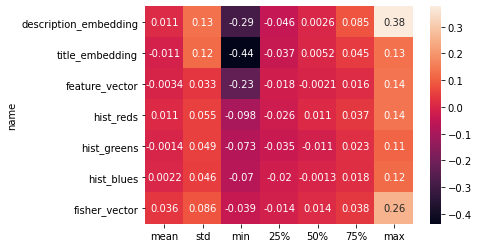

In [18]:
from sklearn.decomposition import PCA

# to_embeddings = ['description_embedding', 'title_embedding'] #, 'hist_reds', 'hist_greens', 'hist_blues', 'fisher_vector']

def trim_size(size):
    if size > 100:
        return int(size * 0.1)
    else:
        return 10
    

embeddings_statistics = []
unwraped_features = {}
for col in tqdm.tqdm(to_embeddings):
    df_temp = df.dropna(axis=0)
    
    unwrapped_df = df_temp.loc[np.logical_not(df_temp[col].isna()), col].apply(lambda x: pd.Series(x, dtype='float32'))
    unwrapped_df = pd.DataFrame(PCA(n_components=trim_size(unwrapped_df.shape[1])).fit_transform(unwrapped_df.values))
    unwrapped_df.index = df_temp.index
    unwrapped_df.columns = [f'{col}_{c}' for c in unwrapped_df.columns]
    unwraped_features[col] = unwrapped_df
    correlation = unwrapped_df.corrwith(df.category_id, method='spearman')

    correlation = correlation.describe()
    correlation['name'] = col
    embeddings_statistics.append(correlation)

stats_df = pd.concat(embeddings_statistics, axis=1).T.set_index('name').astype('float32')
stats_df.drop('count', axis=1, inplace=True)
sns.heatmap(stats_df, annot=True)

In [19]:
unwraped_features[to_embeddings[1]].head()

,title_embedding_0,title_embedding_1,title_embedding_2,title_embedding_3,title_embedding_4,title_embedding_5,title_embedding_6,title_embedding_7,title_embedding_8,title_embedding_9,title_embedding_10,title_embedding_11,title_embedding_12,title_embedding_13,title_embedding_14,title_embedding_15,title_embedding_16,title_embedding_17,title_embedding_18,title_embedding_19
video_id,,,,,,,,,,,,,,,,,,,,
wnwF1FHybDQ,-0.065180,0.042082,-0.049001,0.010678,0.065829,-0.108959,-0.125248,0.017733,-0.207110,-0.031432,0.118076,-0.047414,-0.018533,0.087493,0.149768,-0.028950,0.062834,0.034156,-0.170452,-0.004602
1Wk8ZRgXQnY,0.257572,0.129053,-0.042251,-0.092847,-0.101058,0.020214,-0.150201,-0.110441,0.031951,0.094308,0.080012,0.038058,0.081534,0.170048,0.140338,0.099992,0.014114,-0.105881,-0.108735,0.031303
lsfzA7sWlOM,0.072479,-0.111818,0.286180,-0.314284,-0.036195,0.007705,0.087132,0.052647,0.245792,0.003473,0.011369,-0.134778,-0.092803,-0.033193,0.058691,0.104736,0.037754,-0.053399,0.075992,0.041840
X7flefV8tec,-0.309803,0.070989,0.008950,0.330492,-0.224379,-0.034932,-0.246739,-0.129590,-0.145792,0.087656,-0.075234,0.090421,0.174395,0.023044,0.120657,0.040229,0.039168,-0.063969,-0.040137,0.200011
KJ12FVmumeA,0.044599,-0.212744,0.040184,0.415063,0.062685,0.044515,-0.098938,-0.185685,0.215395,0.037368,-0.005104,-0.007188,0.074040,-0.029678,0.105909,-0.003596,-0.096956,0.104201,-0.032486,-0.051074


### Zapisywanie pośredniego wyniku

In [20]:
df.to_pickle("data/chkp12.pkl")

### Wypełnianie brakująych kategorii

In [21]:
df = pd.read_pickle("data/chkp12.pkl")
df.head(2)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0

In [22]:
df['category_id'].isnull().any()

True

In [23]:
df = df.merge(category_df, on='video_id', how='left')
df['category_id'] = np.max(df[['category_id_x', 'category_id_y']], axis=1)
df.drop(labels=['category_id_x', 'category_id_y'], axis=1, inplace=True)
df.head(2)

,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_text,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,description_embedding,title_embedding,channel_title_hash,is_us,is_gb,feature_vector,people_amount,objects,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,hist_reds,hist_greens,hist_blues,fisher_vector,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,image_text,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue,category_id
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,"[-0.028469370678067207, 0.04915565997362137, 0...",81377,655,25,177,0,0,0,NaN,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,"[0.1286950558423996, 0.09136795997619629, -0.0...","[0.06370916962623596, 0.06371407955884933, -0....",-3.467289e+10,1,0,"[0.06580926, -0.12843476, -0.04167219, -0.0986...",8.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,"[0.23528356481481483, 0.016064814814814816, 0....","[0.2470138888888889, 0.023055555555555555, 0.0...","[0.2572511574074074, 0.01494212962962963, 0.01...","[-1.3669241025582595, 1.6668570796367268, 1.89...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.0565573088824749, 0.10600613057613373, -0....",84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0,17.0
Om_zGhJLZ5U,"[0.02910427376627922, 0.02701600082218647, 0.0...",288922,7515,792,2111,0,0,0,NaN,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,"[0.08945216238498688, 0.012981911189854145, 0....","[0.10034792870283127, 0.018092168495059013, -0...",-2.138384e+10,1,0,"[0.00328945, -0.09353591, 0.4361128, -0.185314...",3.0,"[0.12082629650831223, -0.10840089619159698, 0....",46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,"[0.23725694444444445, 0.015381944444444445, 0....","[0.23922453703703703, 0.015578703703703704, 0....","[0.2574768518518519, 0.01732060185185185, 0.01...","[-1.6507262497608926, 1.7259565315033054, 1.74...",2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.02252897247672081, 0.01694178581237793, -0....",68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0,95

In [24]:
df['category_id'].isnull().any()

False

In [25]:
df.to_pickle("data/chkp12_filled.pkl")

### Usuwanie wartości NaN

In [26]:
df = pd.read_pickle("data/chkp12_filled.pkl")
embeddings_col = ['description_embedding', 'title_embedding', 'feature_vector', 
                  'hist_reds', 'hist_greens', 'hist_blues', 'fisher_vector', 
                  'tags', 'image_text', 'objects', 'category_text']
df.drop(embeddings_col, axis=1, inplace=True)

dist_matrix = nan_euclidean_distances(df.values, df.values)
dist_matrix.shape

(8606, 8606)

In [27]:
df_temp = deepcopy(df)

for i, (idx, row) in enumerate(df_temp.iterrows()):
    closest_idx = np.argmin(np.delete(dist_matrix[i,:], i))
    closest_case = df_temp.iloc[[closest_idx]]
    for col in row.index:
        if pd.isna(row[col]):
            df_temp.at[idx, col] = closest_case[col].values[0]
            if pd.isna(df_temp.at[idx, col]):
                df_temp.at[idx, col] = df_temp[col].mean()

df = df_temp
df.head(3)

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,channel_title_hash,is_us,is_gb,people_amount,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,face_count,count_angry,count_sad,count_neutral,count_disgust,count_surprise,count_fear,count_happy,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue,category_id
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,81377,655,25,177,0,0,0,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,-3.467289e+10,1,0,8.0,46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0,17.0
Om_zGhJLZ5U,288922,7515,792,2111,0,0,0,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,-2.138384e+10,1,0,3.0,46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0,95.0,1.0
goP4Z5wyOlM,34785,308,26,413,0,0,0,12,11,2017,6,4,21,16,40,14,11,2017,1,4,0,26,308,308,0,26,26,0,34785,34785,0,413,413,0,334,0.922156,0.077844,334,0.922156,0.077844,3,48,0,0,3,0,65,671,8,53,517,7,0.815385,0.770492,0.875000,0.000000,0.005803,0.0,10,90.0,2,6.0,0.066667,0.132075,0.160542,0.571429,1.664749e+11,1,0,0.0,43,77,6.982875,-33.0,8276.0,108845.0,119302.0,122061.0,122779.0,123187.0,129621.0,172800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176.130231,232.0,217.5,163.158229,232.0,234.0,145.845683,195.0,209.0,25.0


Sprawdziliśmy wariancję dla wszystkich cech. Okazało się, że cecha `count_disgust` zawiera same zera, dlatego jej wariancja wynosiła 0.
Usuneliśmy tę cechę, bo nic nie wnosi.

In [28]:
df.var().sort_values()[:3]

count_disgust                    0.000000
channel_title_attention_ratio    0.000076
description_attention_ratio      0.000145
dtype: float64

In [29]:
df.drop('count_disgust', axis=1, inplace=True)
df.head(3)

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,channel_title_hash,is_us,is_gb,people_amount,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,face_count,count_angry,count_sad,count_neutral,count_surprise,count_fear,count_happy,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue,category_id
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,81377,655,25,177,0,0,0,13,11,2017,0,4,2,5,26,14,11,2017,1,4,0,21,655,655,0,25,25,0,81377,81377,0,177,177,0,680,0.963235,0.036765,680,0.963235,0.036765,8,127,0,1,3,0,86,1255,3,58,963,3,0.674419,0.767331,1.000000,0.017241,0.003115,0.0,15,177.0,1,16.0,0.090395,0.275862,0.096573,1.000000,-3.467289e+10,1,0,8.0,46,46,12.542644,-143.0,48.0,8008.0,134508.0,150069.0,157884.0,161032.0,165137.0,172800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.459803,79.0,134.0,52.581076,38.0,72.0,44.219300,22.0,56.0,17.0
Om_zGhJLZ5U,288922,7515,792,2111,0,0,0,12,11,2017,6,4,18,0,3,14,11,2017,1,4,0,29,7515,7515,0,792,792,0,288922,288922,0,2111,2111,0,8307,0.904659,0.095341,8307,0.904659,0.095341,2,23,0,0,3,0,46,396,14,37,311,13,0.804348,0.785354,0.928571,0.000000,0.009646,0.0,9,61.0,2,4.0,0.065574,0.351351,0.070740,0.153846,-2.138384e+10,1,0,3.0,46,46,11.607859,-228.0,46.0,3130.0,27840.0,47628.0,88412.0,172800.0,172800.0,172800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,68.507153,31.0,114.0,66.207436,33.0,116.0,57.418987,25.0,95.0,1.0
goP4Z5wyOlM,34785,308,26,413,0,0,0,12,11,2017,6,4,21,16,40,14,11,2017,1,4,0,26,308,308,0,26,26,0,34785,34785,0,413,413,0,334,0.922156,0.077844,334,0.922156,0.077844,3,48,0,0,3,0,65,671,8,53,517,7,0.815385,0.770492,0.875000,0.000000,0.005803,0.0,10,90.0,2,6.0,0.066667,0.132075,0.160542,0.571429,1.664749e+11,1,0,0.0,43,77,6.982875,-33.0,8276.0,108845.0,119302.0,122061.0,122779.0,123187.0,129621.0,172800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176.130231,232.0,217.5,163.158229,232.0,234.0,145.845683,195.0,209.0,25.0


## Macierz korelacji

Należy pamiętać, że **koeralcja to nie przyczynowość!**

- `trending_date_month` oraz `trending_date_year` są silnie odwrotnie skorelowane ze sobą. Jest tak dlatego, że dane nie poktrywają wszystkich miesiący, dlatego jeśli miesiąc jest np: grudźień to zawsze występuje w 2016, a styczeń zawsze w 2017.
- like i dislike (i cechy pochodne) są silnie odwrotnie skorelowane, bo zwykle likeów jest znacznie więcej niż dislików 
- cechy pochodne (np typu count -> ratio) są ze sobą silne skorelowane, ponieważ wywodzą się z tego samego miejsca.
- `is_gb` jest w pewnym stopniu skorelowane z `trending_span_days`

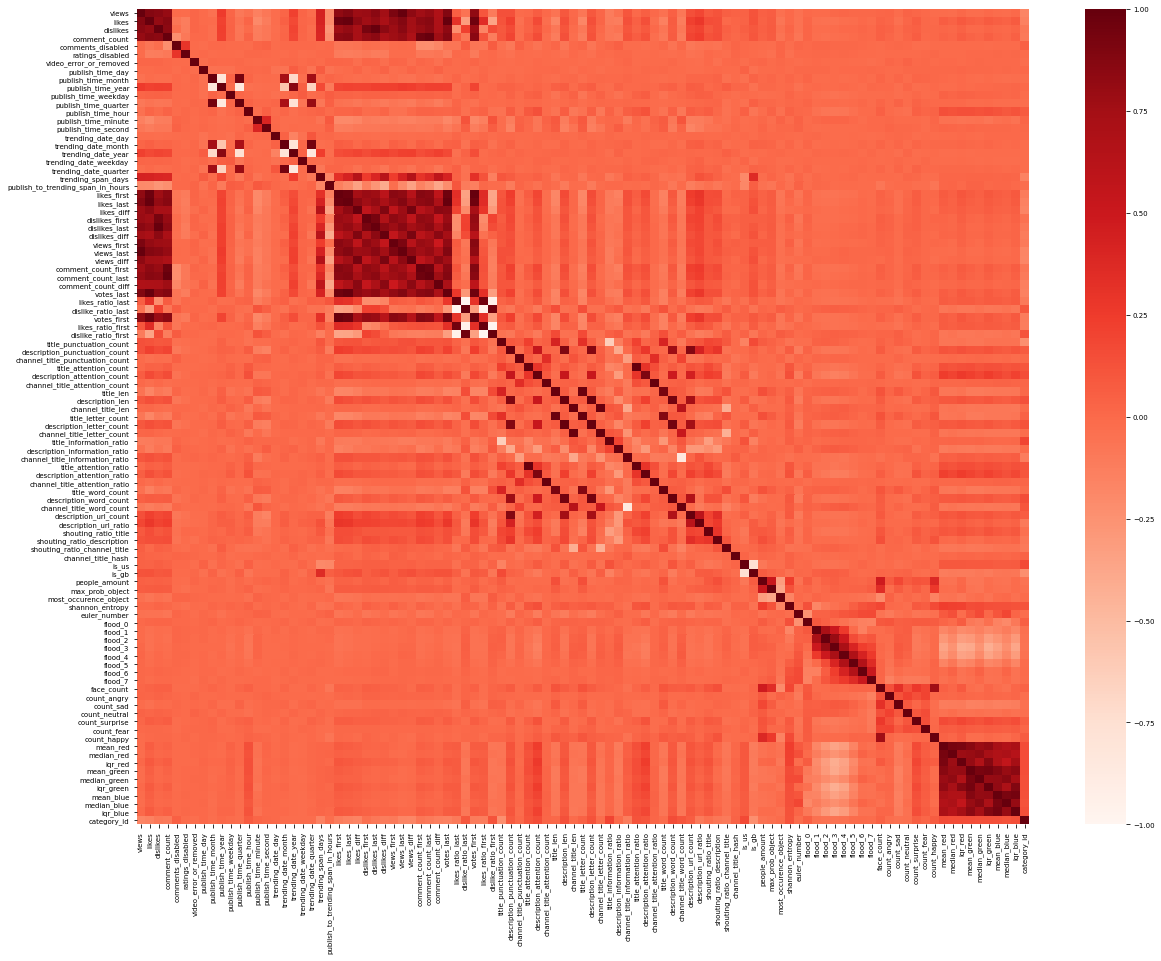

In [30]:
matplotlib.rcParams.update({'font.size': 7})
plt.figure(figsize=(20,15))
cor = df.loc[:, df.columns != 'count_disgust'].corr(method='spearman')
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [31]:
cor_target = abs(cor["category_id"])
relevant_features = cor_target[cor_target>0.16]
relevant_features.sort_values(ascending=False)

category_id                1.000000
is_gb                      0.232691
title_punctuation_count    0.229996
title_information_ratio    0.196702
views_diff                 0.178891
is_us                      0.176895
views                      0.169612
views_last                 0.169464
mean_red                   0.161930
Name: category_id, dtype: float64

Należy usunąć wszystkie silnie skorelowane cechy (między sobą, a nie z wartością docelową) przed procesem uczenia - założenie m.in. regresji logistycznej

In [32]:
best_cols_pearson =  list(relevant_features.index)
for col1, col2 in it.combinations(best_cols_pearson, 2):
    print(df[[col1,col2]].corr())
    print('-'*50)

               views  views_last
views       1.000000    0.999947
views_last  0.999947    1.000000
--------------------------------------------------
               views  views_diff
views       1.000000    0.988179
views_diff  0.988179    1.000000
--------------------------------------------------
                            views  title_punctuation_count
views                    1.000000                 0.102519
title_punctuation_count  0.102519                 1.000000
--------------------------------------------------
                            views  title_information_ratio
views                    1.000000                -0.058043
title_information_ratio -0.058043                 1.000000
--------------------------------------------------
          views     is_us
views  1.000000 -0.041959
is_us -0.041959  1.000000
--------------------------------------------------
          views     is_gb
views  1.000000  0.140374
is_gb  0.140374  1.000000
-------------------------------------

### Macierze korelacji dla kategorii

In [33]:
categories = df['category_id'].unique()
categories = [(i, category_map.loc[float(i)]) for i in categories]
categories

[(17.0, 'Sports'),
 (1.0, 'Film & Animation'),
 (25.0, 'News & Politics'),
 (24.0, 'Entertainment'),
 (28.0, 'Science & Technology'),
 (23.0, 'Comedy'),
 (10.0, 'Music'),
 (27.0, 'Education'),
 (26.0, 'Howto & Style'),
 (2.0, 'Autos & Vehicles'),
 (15.0, 'Pets & Animals'),
 (22.0, 'People & Blogs'),
 (20.0, 'Gaming'),
 (19.0, 'Travel & Events'),
 (29.0, 'Nonprofits & Activism'),
 (43.0, 'Shows')]

In [34]:
for cat, cat_name in categories:
    fig, ax = plt.subplots(figsize=(20,21))
    cor = df.loc[df['category_id'] == cat, df.columns != 'count_disgust'].corr(method='spearman')
    sns.heatmap(cor, cmap=plt.cm.Reds, ax=ax)
    ax.set_title(cat_name)
    fig.tight_layout()
    fig.savefig(f'correlation_matrices/{cat_name}.pdf', bbox_inches='tight')
    plt.clf()

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

<Figure size 1440x1512 with 0 Axes>

### Normalizacja/standaryzacja danych

Używamy RoboustScaler, bo jest odporny na wartości odstające. Zamiast operować na średniej i odchyleniach, operuje na medianie i 25/75 kwantylem (IQR).

In [35]:
X_df, y_df = df.drop('category_id',1), df['category_id']

In [36]:
from sklearn.preprocessing import RobustScaler, StandardScaler

df.loc[:, df.columns != 'category_id' ] = RobustScaler(quantile_range=(5,95)).fit_transform(X_df.values)
df.head(3)

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_time_day,publish_time_month,publish_time_year,publish_time_weekday,publish_time_quarter,publish_time_hour,publish_time_minute,publish_time_second,trending_date_day,trending_date_month,trending_date_year,trending_date_weekday,trending_date_quarter,trending_span_days,publish_to_trending_span_in_hours,likes_first,likes_last,likes_diff,dislikes_first,dislikes_last,dislikes_diff,views_first,views_last,views_diff,comment_count_first,comment_count_last,comment_count_diff,votes_last,likes_ratio_last,dislike_ratio_last,votes_first,likes_ratio_first,dislike_ratio_first,title_punctuation_count,description_punctuation_count,channel_title_punctuation_count,title_attention_count,description_attention_count,channel_title_attention_count,title_len,description_len,channel_title_len,title_letter_count,description_letter_count,channel_title_letter_count,title_information_ratio,description_information_ratio,channel_title_information_ratio,title_attention_ratio,description_attention_ratio,channel_title_attention_ratio,title_word_count,description_word_count,channel_title_word_count,description_url_count,description_url_ratio,shouting_ratio_title,shouting_ratio_description,shouting_ratio_channel_title,channel_title_hash,is_us,is_gb,people_amount,max_prob_object,most_occurence_object,shannon_entropy,euler_number,flood_0,flood_1,flood_2,flood_3,flood_4,flood_5,flood_6,flood_7,face_count,count_angry,count_sad,count_neutral,count_surprise,count_fear,count_happy,mean_red,median_red,iqr_red,mean_green,median_green,iqr_green,mean_blue,median_blue,iqr_blue,category_id
video_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9wRQljFNDW8,-0.047171,-0.042619,-0.040205,-0.043771,0.0,0.0,0.0,-0.074074,0.636364,-1.0,-0.5,0.666667,-0.619048,-0.178571,0.181818,-0.037037,0.636364,-1.0,-0.333333,0.666667,-0.230769,-0.025424,-0.046341,-0.042779,-0.022369,-0.044524,-0.039991,-0.022996,-0.057940,-0.047263,-0.027998,-0.044188,-0.043792,-0.027646,-0.044171,-0.005987,0.005987,-0.048309,-0.034158,0.034158,1.2,0.262500,0.0,1.0,0.181818,0.0,0.558824,0.200279,-0.36,0.377358,0.199559,-0.380952,-0.562791,-0.101146,0.385185,0.413793,0.097863,0.0,0.636364,0.223016,-0.25,0.391304,0.164649,0.081481,-0.055331,0.861538,-0.023493,0.0,0.0,1.4,0.000000,0.00000,0.213723,-0.181132,0.078947,-0.093196,0.380827,0.220693,0.088947,-0.082086,-0.120494,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,-0.013582,0.057592,-0.044554,-0.230157,-0.124242,-0.270782,-0.284435,-0.209877,-0.313823,17.0
Om_zGhJLZ5U,-0.022875,-0.014879,0.038462,0.037665,0.0,0.0,0.0,-0.111111,0.636364,-1.0,0.5,0.666667,0.142857,-0.267857,-0.236364,-0.037037,0.636364,-1.0,-0.333333,0.666667,-0.230769,0.008475,0.002435,-0.015039,-0.022369,0.133341,0.038157,-0.022996,0.015402,-0.022998,-0.027998,0.079309,0.037644,-0.027646,-0.014417,-0.217287,0.217287,0.004614,-0.271378,0.271378,0.0,-0.170833,0.0,0.0,0.181818,0.0,-0.029412,-0.141748,0.08,-0.018868,-0.138396,0.095238,0.060870,0.044155,0.013757,0.000000,0.558418,0.0,0.090909,-0.108649,0.00,-0.130435,0.032266,0.162563,-0.174465,-0.049704,-0.009383,0.0,0.0,0.4,0.000000,0.00000,0.060673,-0.364420,0.071429,-0.132936,-0.297077,-0.405169,-0.378368,0.026306,0.000000,0.0,0.5,1.0,1.0,0.0,0.0,0.0,0.0,-0.155513,-0.193717,-0.143564,-0.101301,-0.154545,-0.047148,-0.160596,-0.191358,-0.119552,1.0
goP4Z5wyOlM,-0.052626,-0.044022,-0.040103,-0.033833,0.0,0.0,0.0,-0.111111,0.636364,-1.0,0.5,0.666667,0.285714,0.017857,0.436364,-0.037037,0.636364,-1.0,-0.333333,0.666667,-0.230769,-0.004237,-0.048808,-0.044182,-0.022369,-0.044292,-0.039889,-0.022996,-0.074405,-0.052710,-0.027998,-0.029118,-0.033854,-0.027646,-0.045520,-0.154171,0.154171,-0.050710,-0.200520,0.200520,0.2,-0.066667,0.0,0.0,0.181818,0.0,0.250000,-0.032252,-0.16,0.283019,-0.031619,-0.190476,0.113846,-0.075660,-0.264815,0.000000,0.287376,0.0,0.181818,-0.025733,0.00,-0.043478,0.038095,-0.072956,0.239665,0.

# Wybieranie cech
### Funkcja podsumowująca rankingi

In [37]:
from typing import Callable, List, Tuple
from collections import defaultdict
from operator import itemgetter

def combine_rankings(rankings: List[pd.Series]):
    scores = defaultdict(int)
    for ranking in rankings:
        for name, rank in zip(ranking.index, ranking):
            scores[name] += rank

    return sorted(scores.items(), key=itemgetter(1))

names = ['a','b','c','d']
combine_rankings([
        pd.Series([0,1,2,3], index=names),
        pd.Series([1,0,3,2], index=names)
])

[('a', 1), ('b', 1), ('c', 5), ('d', 5)]

In [38]:
from sklearn.feature_selection import VarianceThreshold

def rank_by_variance(df, threshold=0.01, target_name = 'category_id'):
    features = df.drop(target_name, axis=1)
    variances = features.var()
    return pd.Series(variances > threshold, index=features.columns, dtype=np.uint8)

rank_by_variance(df).sort_values()

channel_title_attention_count    0
ratings_disabled                 0
video_error_or_removed           0
channel_title_attention_ratio    0
views                            1
                                ..
views_last                       1
views_first                      1
dislikes_diff                    1
dislike_ratio_last               1
iqr_blue                         1
Length: 98, dtype: uint8

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

def rank_by_function(df, score_func, ascending=True, target_name = 'category_id'):
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    fs = SelectKBest(score_func=score_func, k='all')
    fs.fit_transform(X, y)
    
    series = pd.Series(fs.scores_, index=X.columns).sort_values(ascending=ascending)
    return pd.Series(range(len(series)), index=series.index)

In [40]:
rank_by_function(df, score_func=f_classif, ascending=False)

shouting_ratio_channel_title     0
dislike_ratio_last               1
likes_ratio_last                 2
likes_ratio_first                3
dislike_ratio_first              4
                                ..
flood_0                         93
publish_time_day                94
video_error_or_removed          95
trending_date_weekday           96
trending_date_day               97
Length: 98, dtype: int64

#### Mutual Information Feature Selection
https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [41]:
rank_by_function(df, score_func=mutual_info_classif, ascending=False)

channel_title_hash                  0
shouting_ratio_channel_title        1
channel_title_len                   2
channel_title_information_ratio     3
channel_title_letter_count          4
                                   ..
count_fear                         93
count_neutral                      94
ratings_disabled                   95
channel_title_punctuation_count    96
trending_date_weekday              97
Length: 98, dtype: int64

In [42]:
rank_by_function(np.abs(df), score_func=chi2, ascending=False)

publish_to_trending_span_in_hours     0
views_diff                            1
flood_0                               2
views                                 3
views_last                            4
                                     ..
channel_title_attention_ratio        93
publish_time_minute                  94
publish_time_second                  95
trending_date_day                    96
publish_time_day                     97
Length: 98, dtype: int64

In [43]:
def rank_by_rfe(df, n_features = 3, target_name = 'category_id'):
    X, y = df.drop(target_name, axis=1), df[target_name]

    lr = LogisticRegression()
    rfe = RFE(lr, n_features_to_select=X.shape[1]-1)
    X_rfe = rfe.fit_transform(X, y)
    lr.fit(X_rfe, y)

    return pd.Series(rfe.support_, index = X_df.columns)
    # rfe_cols = rfe_temp[rfe_temp == True].index.tolist()
    # rfe_cols

# rank_by_rfe(df)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


shouting_ratio_channel_title      0
channel_title_len                 1
channel_title_letter_count        2
channel_title_hash                3
shouting_ratio_title              4
                                 ..
comments_disabled                93
channel_title_attention_ratio    94
channel_title_attention_count    95
ratings_disabled                 96
video_error_or_removed           97
Length: 98, dtype: int64

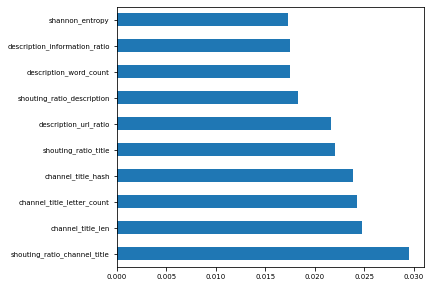

In [44]:
def rank_by_clf_importance(df, clf, ascending=False, target_name = 'category_id', ranking=True):
    X, y = df.drop(target_name, axis=1), df[target_name]
    clf.fit(X, y)
    if not ranking:
        return pd.Series(clf.feature_importances_, index=X.columns)
    else:
        series = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=ascending)
        return pd.Series(range(len(series)), index=series.index)


clf = RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)
rank_by_clf_importance(df, clf, ranking=False).nlargest(10).plot(kind='barh')
plt.tight_layout()
plt.grid(False)
plt.plot()

rank_by_clf_importance(df, clf, ranking=True)

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

final_ranking = combine_rankings([
    # rank_by_variance(df).index,
    rank_by_function(df, score_func=f_classif, ascending=False),
    rank_by_function(df, score_func=mutual_info_classif, ascending=False),
    rank_by_clf_importance(df, RandomForestClassifier(n_jobs=-1, random_state=42)),
    rank_by_clf_importance(df, ExtraTreesClassifier(n_jobs=-1, random_state=42))
    # rank_by_function(np.abs(df), score_func=chi2, ascending=False).index,
])

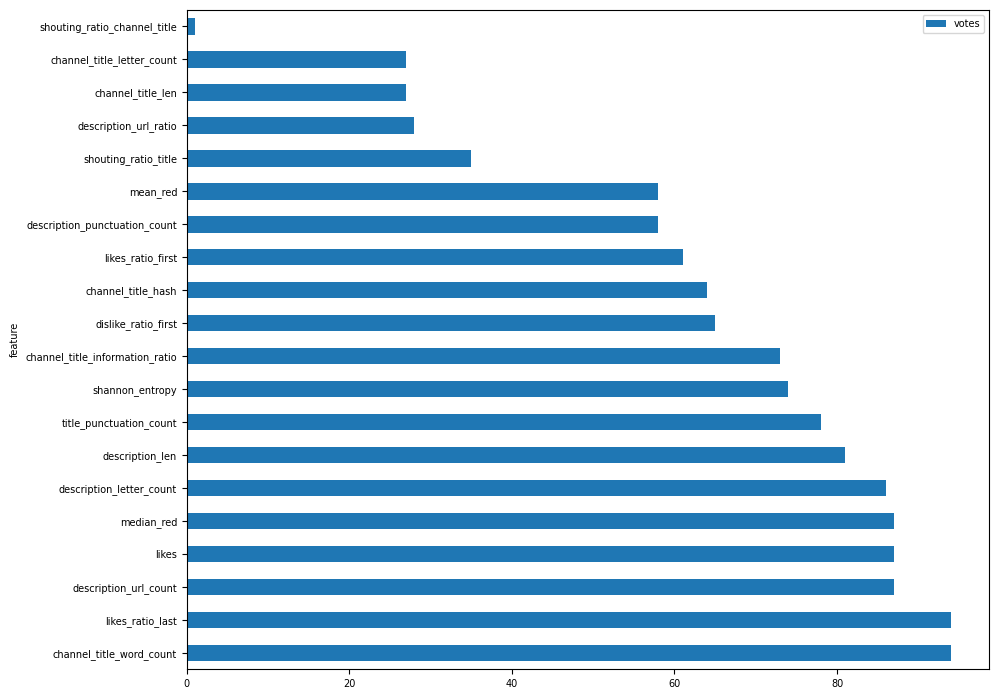

In [46]:
fig, ax = plt.subplots(figsize=(10,7), dpi=100)
ranking_df = pd.DataFrame(final_ranking)
ranking_df.columns = ['feature', 'votes']
ranking_df.set_index('feature').nsmallest(20, columns='votes').loc[::-1,:].plot(kind='barh', ax=ax)
fig.tight_layout()

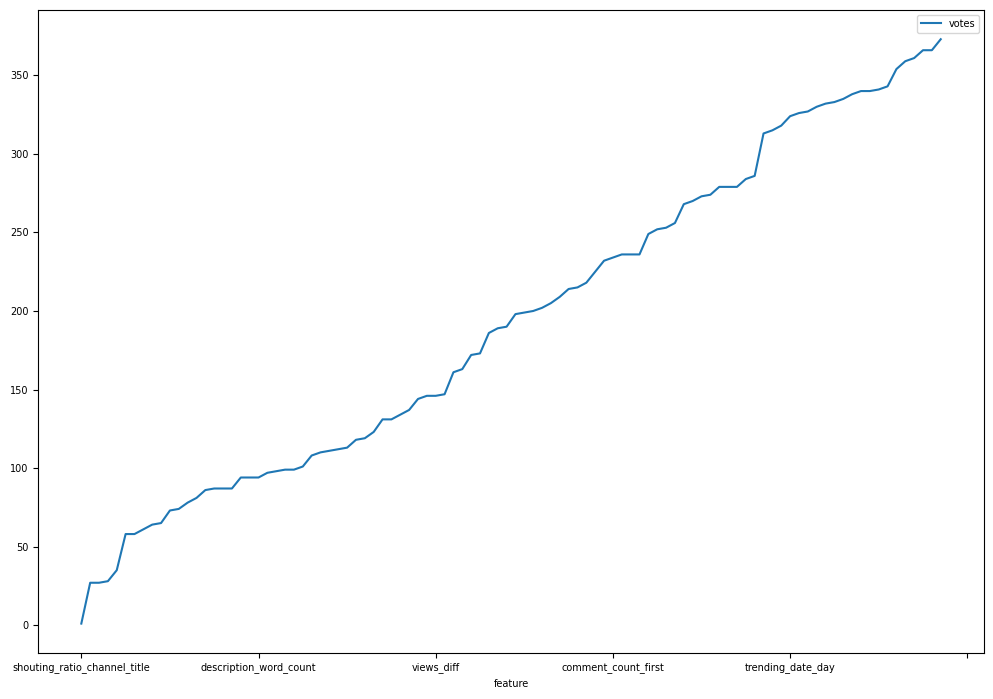

In [47]:
fig, ax = plt.subplots(figsize=(10,7), dpi=100)
ranking_df = pd.DataFrame(final_ranking)
ranking_df.columns = ['feature', 'votes']
ranking_df.set_index('feature').sort_values('votes').plot(ax=ax)
fig.tight_layout()

## Istotność trójek cech oparta o strukturę hipergrafową

In [ ]:
# from hypper.hypergraph import HyperGraph
# from hypper.preprocessing import Preprocess

# df_pp = Preprocess(df).run_discretization(method='sturges', label_to_ignore=None)
# hg = HyperGraph(df_pp, label='category_id')
# with open('data/hypergraph_strucutre.pkl', 'wb') as handle:
#     pickle.dump(hg, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/hypergraph_strucutre.pkl', 'rb') as handle:
    hg = pickle.load(handle)

rw = hg.random_walk(iterations=1000000)

 56%|█████▋    | 563920/1000000 [00:45<00:34, 12661.20it/s]

In [ ]:
for i, ((f1, f2, f3), _) in enumerate(rw.most_common(10)):
    print(f'{i+1}. {hg.edges[f1]} - {hg.edges[f2]} - {hg.edges[f3]}')